<a href="https://colab.research.google.com/github/saqib-sarwar/plant-leaves/blob/main/Plant_leaves_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
from torchvision import transforms, models, datasets

import matplotlib.pyplot as plt
import time
import copy

In [ ]:
import zipfile
import os


!wget --no-check-certificate \
    "https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip" \
    -O "/tmp/plantdoc-cropped.zip"


zip_ref = zipfile.ZipFile('/tmp/plantdoc-cropped.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-09-16 19:36:03--  https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/pratikkayal/PlantDoc-Dataset/zip/refs/heads/master [following]
--2022-09-16 19:36:03--  https://codeload.github.com/pratikkayal/PlantDoc-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/plantdoc-cropped.zip’

/tmp/plantdoc-cropp     [   <=>              ] 938.81M  22.8MB/s    in 44s     

2022-09-16 19:36:47 (21.2 MB/s) - ‘/tmp/plantdoc-cropped.zip’ saved [984413268]



In [ ]:
print('Test set Bell pepper' , len(os.listdir('/tmp/PlantDoc-Dataset-master/test/Bell_pepper leaf')))
print('Train set Corn Rust' , len(os.listdir('/tmp/PlantDoc-Dataset-master/train/Corn rust leaf')))

Test set Bell pepper 8
Train set Corn Rust 106


In [ ]:
IMG_SIZE = 256
CROP_SIZE = 224
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.004
DATA_PATH = "/tmp/PlantDoc-Dataset-master/"
TRAIN_DATA_PATH = "/tmp/PlantDoc-Dataset-master/train/"
TEST_DATA_PATH = "/tmp/PlantDoc-Dataset-master/test/"
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_classes = len(class_names)

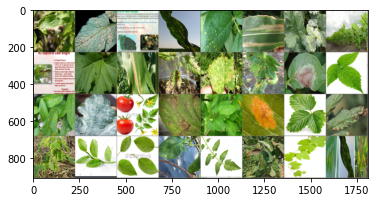

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #if title is not None:
    #    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, scale_each=True)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
logdir = 'runs/plant_leaves'
writer = SummaryWriter(logdir)

In [ ]:
PATIENCE = 3

In [ ]:
# Training
def train_model(model, criterion, optimizer, scheduler, epochs=EPOCHS):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_train_idx = 0
    loss_test_idx = 0

    patience = PATIENCE

    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)
  
        # Iterate over the DataLoader for training data
        for i, data in enumerate(dataloaders['train'], 0):
      
        # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)

            # Write the network graph at epoch 0, batch 0
            if epoch == 0 and i == 0:
                writer.add_graph(model, input_to_model=data[0].to(device), verbose=False)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    writer.add_scalar('Running_Loss/Train', running_loss, loss_train_idx)
                    loss_train_idx += 1
                else:
                    writer.add_scalar('Running_Loss/Test', running_loss, loss_test_idx)
                    loss_test_idx += 1
          
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                writer.add_scalar('Loss/Train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
            else:
                writer.add_scalar('Loss/Test', epoch_loss, epoch)
                writer.add_scalar('Accuracy/Test', epoch_acc, epoch)

            # deep copy the model
            if phase == 'test':
                if epoch_acc > best_acc:
                    patience = PATIENCE
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    patience -= 1

        # early stopping
        if patience == 0:
            print("Early stopping")
            break

        print()

    writer.close()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Visualize Predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.mobilenet_v3_large(pretrained=True)
print(model_ft)

In [ ]:
in_ft = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(in_ft, num_classes)
model_ft.to(device)

last_conv_layer = model_ft.features[-1][0]

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
# Training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       epochs=EPOCHS)

Epoch 0/19
----------
train Loss: 3.0564 Acc: 0.1853
test Loss: 2.7449 Acc: 0.2331

Epoch 1/19
----------
train Loss: 2.2332 Acc: 0.4278
test Loss: 2.2883 Acc: 0.3686

Epoch 2/19
----------
train Loss: 1.7001 Acc: 0.5568
test Loss: 2.0164 Acc: 0.4237

Epoch 3/19
----------
train Loss: 1.3489 Acc: 0.6422
test Loss: 1.8723 Acc: 0.4788

Epoch 4/19
----------
train Loss: 1.1103 Acc: 0.6998
test Loss: 1.8179 Acc: 0.4703

Epoch 5/19
----------
train Loss: 0.9674 Acc: 0.7519
test Loss: 1.7931 Acc: 0.4703

Epoch 6/19
----------
train Loss: 0.9206 Acc: 0.7673
test Loss: 1.7868 Acc: 0.4873

Epoch 7/19
----------
train Loss: 0.9077 Acc: 0.7613
test Loss: 1.7804 Acc: 0.4873

Epoch 8/19
----------
train Loss: 0.9040 Acc: 0.7690
test Loss: 1.7744 Acc: 0.4915

Epoch 9/19
----------
train Loss: 0.8765 Acc: 0.7801
test Loss: 1.7701 Acc: 0.4958

Epoch 10/19
----------
train Loss: 0.8695 Acc: 0.7792
test Loss: 1.7708 Acc: 0.4958

Epoch 11/19
----------
train Loss: 0.8629 Acc: 0.7869
test Loss: 1.7695 Acc

In [ ]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir="runs/plant_leaves"

Reusing TensorBoard on port 6006 (pid 100), started 2:21:05 ago. (Use '!kill 100' to kill it.)

<IPython.core.display.Javascript object>

tensor([26, 12, 20,  1,  5, 24,  1, 16, 21,  5, 10, 24,  9, 15, 18,  8,  8,  0,
        18, 19,  0, 14, 16, 14,  5, 21,  9,  1,  9, 10, 19, 20])


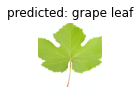

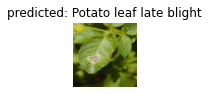

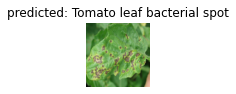

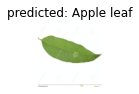

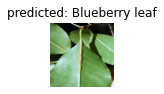

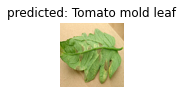

In [ ]:
visualize_model(model_ft)

In [ ]:
# Grad-CAM
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

import cv2
from PIL import Image

In [ ]:
images_for_cam = [
    "/tmp/PlantDoc-Dataset-master/train/Bell_pepper leaf/007.JPG.jpg",
    "/tmp/PlantDoc-Dataset-master/test/Apple rust leaf/4-apple-rust2_19011_matt-bertone.jpg",
    "/tmp/PlantDoc-Dataset-master/train/Blueberry leaf/4715f288527ab7feae1683179ae3073b--red-leaves-autumn-leaves.jpg",
    "/tmp/PlantDoc-Dataset-master/train/Blueberry leaf/5920105029_2c657564ba_b.jpg",
    "/tmp/PlantDoc-Dataset-master/test/Apple Scab Leaf/816.jpg",
    "/tmp/PlantDoc-Dataset-master/test/Bell_pepper leaf/GREEN%20BELL%20PLANT%20YELLOW%20LEAF.JPG.jpg",
    "/tmp/PlantDoc-Dataset-master/test/Corn leaf blight/0c.jpg",
    "/tmp/PlantDoc-Dataset-master/test/Soyabean leaf/resistance1c.jpg",
    "/tmp/PlantDoc-Dataset-master/test/Tomato leaf late blight/LateBlt09_06.jpg",
    "/tmp/PlantDoc-Dataset-master/test/grape leaf black rot/5-29black-rot-chardRR.jpg"
]

In [ ]:
rgb_imgs = []
input = []
transform = transforms.Resize((IMG_SIZE,IMG_SIZE))
for i in range(len(images_for_cam)):

  rgb_imgs.append(cv2.imread(images_for_cam[i]))
  rgb_imgs[i] = (Image.open(images_for_cam[i]))
  rgb_imgs[i] = transform(rgb_imgs[i])
  rgb_imgs[i] = (np.float32(rgb_imgs[i]) / 255)

  input.append(preprocess_image(rgb_imgs[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
  input[i] = input[i].to(device)


In [ ]:

target_layers = [last_conv_layer]

# input_tensor = input_tensor # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam_g = GradCAM(model=model_ft, target_layers=target_layers, use_cuda=torch.cuda.is_available())
cam_gp = GradCAMPlusPlus(model=model_ft, target_layers=target_layers, use_cuda=torch.cuda.is_available())
cam_s = ScoreCAM(model=model_ft, target_layers=target_layers, use_cuda=torch.cuda.is_available())


In [ ]:
torch.cuda.empty_cache()


100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


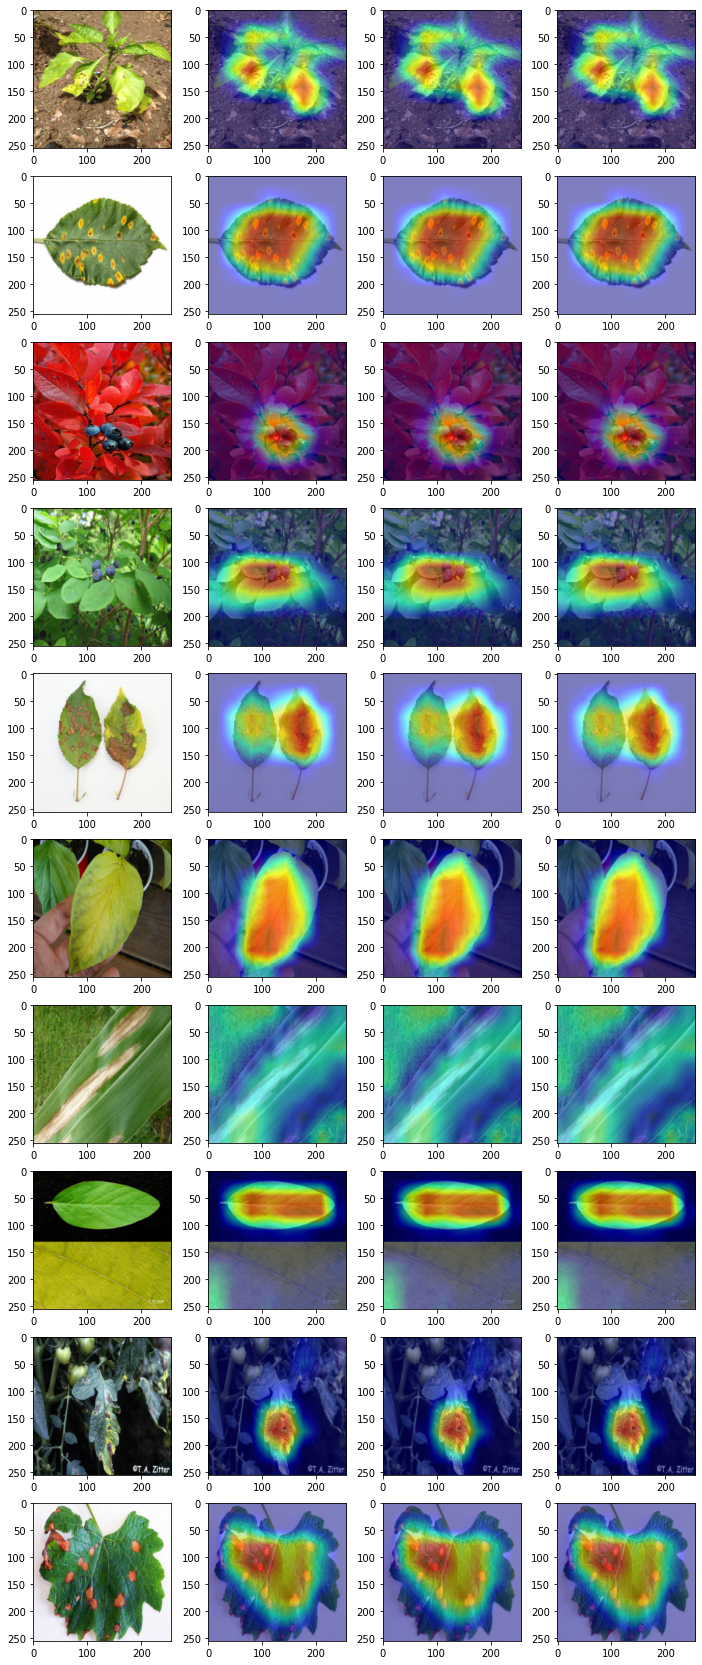

In [ ]:
f, ax = plt.subplots(len(images_for_cam),4, figsize=(12,30))
for i in range(len(images_for_cam)):
    grayscale_cam_g = cam_g(input_tensor=input[i], targets=None, aug_smooth=True, eigen_smooth=True)
    grayscale_cam_g = grayscale_cam_g[0, :]
    visualization_g = show_cam_on_image(rgb_imgs[i], grayscale_cam_g, use_rgb=True)

    grayscale_cam_gp = cam_gp(input_tensor=input[i], targets=None, aug_smooth=True, eigen_smooth=True)
    grayscale_cam_gp = grayscale_cam_gp[0, :]
    visualization_gp = show_cam_on_image(rgb_imgs[i], grayscale_cam_g, use_rgb=True)

    grayscale_cam_s = cam_s(input_tensor=input[i], targets=None, aug_smooth=True, eigen_smooth=True)
    grayscale_cam_s = grayscale_cam_s[0, :]
    visualization_s = show_cam_on_image(rgb_imgs[i], grayscale_cam_g, use_rgb=True)

    ax[i][0].imshow(rgb_imgs[i])
    ax[i][1].imshow(visualization_g)
    ax[i][2].imshow(visualization_gp)
    ax[i][3].imshow(visualization_s)

**Test on Plant Village Dataset**